# Scoring correlation

## Explanation

This notebook can be used to visualize and quantify the difference between DCA, ESM, and true protein structure outputs.

## Setup

### Imports

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

### Helper functions

In [2]:
vmin, vmax = 0, 1
SYMMETRIC = True
# Filter predictions that are greater than "dist" and then take the top L
def filter_L(df:pd.DataFrame, L:int=90, dist:int=4):
    return df[df.apply(lambda df: df["i"] + dist < df["j"], axis=1)][:L].reset_index(drop=True)

# create dataframe of ranked pairs from ESM contact matrix
def df_from_esm_contact_matrix(contact_matrix):
    
    gather = []
    
    # traverse over upper right triangle, exlucding main diagonal
    for i in range(contact_matrix.shape[0]):
        for j in range(0 if SYMMETRIC else i+1, contact_matrix.shape[1]):
            # SANITY check the matrix should be symmetric
            assert contact_matrix[i][j] == contact_matrix[j][i]
            row_dict = dict(
                i = i,
                j = j,
                prob = contact_matrix[i,j]
            )
            
            gather.append(row_dict)

    return pd.DataFrame(gather).sort_values(by='prob', ascending = False)
def data_2d(df, symmetric=SYMMETRIC):
    dim = max(df["i"].max() + 1, df["j"].max() + 1)
    data = np.zeros([dim] * 2)
    for i in range(df.shape[0]):
        data[df['i'][i],df['j'][i]] = df['prob'][i]
        if symmetric:
            data[df['j'][i],df['i'][i]] = df['prob'][i]
    return dim, data

def data_padder(dfs):
    dim, datas = 0, []
    for df in dfs:
        new_dim, data = data_2d(df)
        if new_dim > dim:
            dim = new_dim
        datas.append(data)
    returned = []
    for d in datas:
        returned.append(np.pad(d, ((0, dim - d.shape[0]), (0, dim - d.shape[1]))))
    return returned
        

def heatmap_creator(dfs):
    if type(dfs) == list:
        datas = data_padder(dfs)
        data = np.ones_like(datas[0])
        for array in datas:
            data *= array
    else:
        _, data = data_2d(dfs)
    # Create subplots
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot the first heatmap
    #im1 = ax.imshow(data, cmap='inferno', vmin=vmin, vmax=vmax)
    #ax.set_title("Contact Heatmap")
    plt.imshow(data, vmin=data.min(), vmax=data.max())
    plt.colorbar(orientation='vertical', fraction=0.02, pad=0.1)


    # Add a single colorbar
    #cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
    #cbar.set_label("Color Scale")
    #plt.imshow(data) 
    plt.show()
    #return data

def comparer(dfs):
    datas = data_padder(dfs)
    data = np.ones_like(datas[0])
    for array in datas:
        data *= array
    return data > 0

## Load data

### Load ESM data

In [3]:
esm_results_path = os.path.join('..', 'results/cadherin/esmfold/results.zip')
esm_results = np.load(esm_results_path)
job_name = 'cadherin'

#number of sequences in Cadherin MSA
num_seqs = 55
#esm_results.keys()
esm_dfs = []
for i in range(num_seqs):
    # index into NPzFile object with file name
    contact_matrix = esm_results[f'{i}_{job_name}']
    df = df_from_esm_contact_matrix(contact_matrix)
    esm_dfs.append(df)
    
for i in range(len(esm_dfs)):
    esm_dfs[i] = df.sort_values(by="prob", ascending=False).reset_index(drop=True)

### Load True Contacts

In [4]:
real_contacts_path = os.path.join('..', 'data', 'cadherin', 'PF00028_real_contacts.csv')
real_contacts = np.genfromtxt(real_contacts_path,delimiter=',') # import
real_contacts_df = pd.DataFrame(real_contacts).astype(int)
for i in [0,1]:
    real_contacts_df["i" if i==1 else "j"] = real_contacts_df[i].astype(int) # convert to ints
real_contacts_df["prob"] = 1 # rename columns
real_contacts_df = real_contacts_df[["i", "j", "prob"]] # take only reformatted, renamed columns


### Load DCA data

In [5]:
# Load Motherfuckin DCA results 
mfdca_results_path = os.path.join('..', 'data', 'cadherin', 'PF00028_mfdca.csv')
mfdca_results = np.genfromtxt(mfdca_results_path,delimiter=',') # import
mfdca_df = pd.DataFrame(mfdca_results).iloc[1:,1:] # drop empty columns and header row
for i in [1,2]:
    mfdca_df["i" if i==1 else "j"] = mfdca_df[i].astype(int) # convert to ints
mfdca_df["prob"] = mfdca_df[3] # rename columns
mfdca_df = mfdca_df[["i", "j", "prob"]] # take only reformatted, renamed columns
mfdca_df = mfdca_df.sort_values(by="prob", ascending=False).reset_index(drop=True) # sort by descending score and reset index
# Load PLM DCA results TODO: CURRENTLY A STAND-IN
plmdca_results_path = os.path.join('..', 'data', 'cadherin', 'PF00028_plmdca.csv')
plmdca_results = np.genfromtxt(plmdca_results_path,delimiter=',')
plmdca_df = pd.DataFrame(plmdca_results)
for i in [0,1]:
    plmdca_df["i" if i==0 else "j"] = plmdca_df[i].astype(int) # convert to ints
plmdca_df["prob"] = plmdca_df[2] # rename columns
plmdca_df = plmdca_df[["i", "j", "prob"]] # take only reformatted, renamed columns
plmdca_df = plmdca_df.sort_values(by="prob", ascending=False).reset_index(drop=True) # sort by descending score and reset index

## Process Data

### Take Top L

In [6]:
# replace with whatever L (length of true structure file protein) should actually be
# for the precision@L calculations

# NOTE: these indices are relative to the sequence, not MSA
# NOTE: only include unique pairs if i,j exists then j,i does not and i != j
# NOTE: For correlation residue plots, filter out residues 4 or less apart

top_L_esm = filter_L(esm_dfs[0])
top_L_mf = filter_L(mfdca_df)
top_L_plm = filter_L(plmdca_df)

### Heat maps

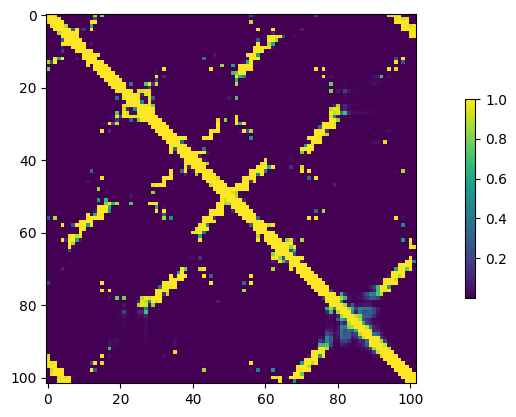

In [7]:
heatmap_creator(esm_dfs[0])

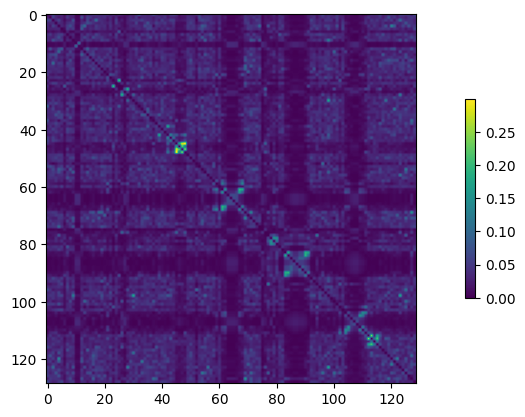

In [8]:
heatmap_creator(mfdca_df)

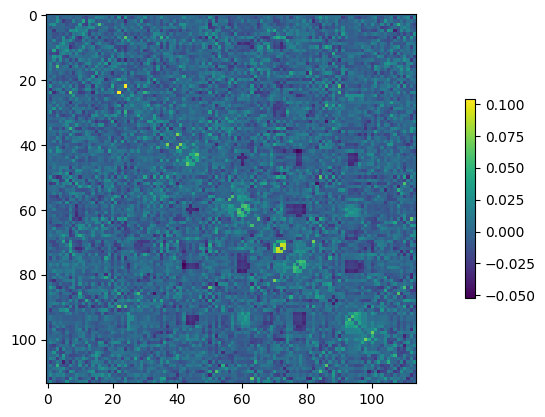

In [9]:
heatmap_creator(plmdca_df)

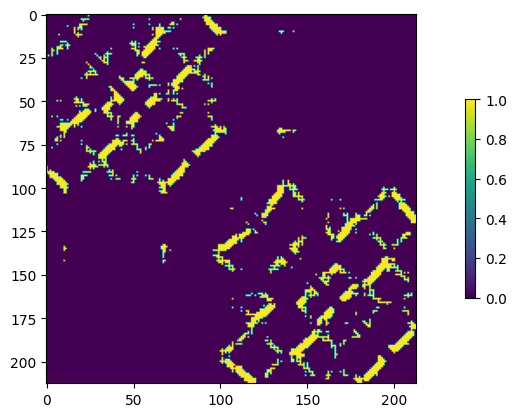

In [10]:
d=heatmap_creator(real_contacts_df)

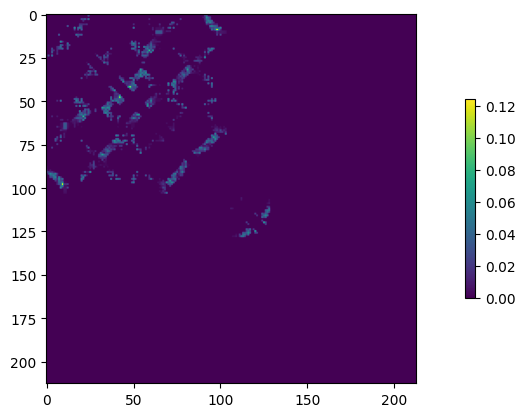

In [11]:
heatmap_creator([real_contacts_df, mfdca_df])

### Correlation

In [ ]:
corr, p = spearmanr(np.random.random([10,10]), np.random.random([10,10]))